In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
%cd ..

/cis/home/dpacker/my_documents/dark-matter-halos


In [2]:
from pathlib import Path
import pandas as pd
from src.pipeline.pipeline import *
from src.summarize.oat import oat_validate_knn
from jax import numpy as jnp
import jax
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [159]:
root_path = Path(".")
data_path = root_path / "data"
gen_data_path = root_path / "generated_data_extended"
results_path = root_path / "results" / "cross_validation"

features_and_targets = jnp.load(gen_data_path / "features_and_targets.npz")
subsampled_data = jnp.load(gen_data_path / "kmeans_subsampled_n1_s75.npz")

n_halos = 500

# Generating the train-test split: keep fixed seed of 0
rng = jax.random.PRNGKey(0)
prop_train = 0.75
prop_test = 0.25

n_train = int(n_halos * prop_train)
n_test = n_halos - n_train

train_indices = jax.random.choice(rng, n_halos, [n_train], replace=False)
test_indices = jnp.array(
    list(set(range(n_halos)) - set([ix.item() for ix in list(train_indices)]))
)
np.savetxt(gen_data_path / "train_indices.txt", np.array(train_indices), fmt="%i")
np.savetxt(gen_data_path / "test_indices.txt", np.array(test_indices), fmt="%i")

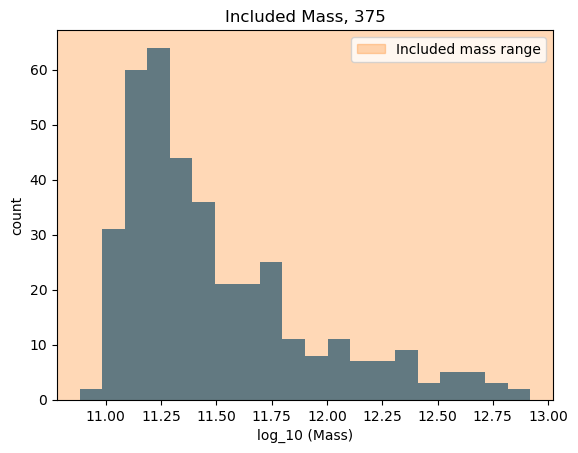

In [174]:
# We'll include mass-slicing so that we can go back to a thin slice if necessary:
mass_range = (-11.1, 101.3)  # set to (-np.inf, np.inf) to include everything
train_log_m = np.log10(features_and_targets["Group_M_Crit200"][train_indices])
train_sliced_mass_ix = train_indices[
    np.argwhere((train_log_m > mass_range[0]) & (train_log_m < mass_range[1]))[:, 0]
]
fig, ax = plt.subplots()
ax: plt.Axes = ax

ax.hist(train_log_m, bins=20)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

ax.fill_betweenx(
    y=[-1, 1e6],
    x1=[mass_range[1], mass_range[1]],
    x2=[mass_range[0], mass_range[0]],
    color="C1",
    alpha=0.3,
    label="Included mass range"
)
ax.set(xlim=xlim, ylim=ylim, title=f"Included Mass, {len(train_sliced_mass_ix)}", xlabel="log_10 (Mass)", ylabel="count")
ax.legend()

In [175]:
t = 0 # k-means trial number
weights_subsampled = subsampled_data["weights"][train_sliced_mass_ix, t]
points_subsampled = subsampled_data["points"][train_sliced_mass_ix, t]
velocities_subsampled = subsampled_data["velocities"][train_sliced_mass_ix, t]

train_stellar_mass = features_and_targets["StellarMass"][train_sliced_mass_ix]
train_labels = jnp.log10(train_stellar_mass * 1e10 / 0.677)  # label by logMstar
train_concentration = features_and_targets["SubhaloC200"][train_sliced_mass_ix]
train_mass = jnp.log10(features_and_targets["Group_M_Crit200"][train_sliced_mass_ix])
train_stellar_metallicity = features_and_targets["StellarMetallicity"][
    train_sliced_mass_ix
]
train_star_formation_rate = features_and_targets["StarFormRate"][train_sliced_mass_ix]

problem_context = ProblemContext(
    points=points_subsampled,
    weights=weights_subsampled,
    velocities=velocities_subsampled,
    masses=train_mass,
    concentrations=train_concentration,
    labels=jnp.log10(
        train_stellar_mass * 1e10 / 0.677
    ),  # label by logMstar (I don't know what this comment means -Dan)
    # labels=train_stellar_metallicity
    # labels=train_star_formation_rate,
)

In [176]:
hyperparametrization = Hyperparametrization(
    rescale_strategy=["unitless"],
    p=1.,
    q=1.,
    tau=10.,
    alpha_C=np.logspace(-2, 2, num=11, base=10, endpoint=True),
    alpha_M=1.0,
    alpha_SLB=np.logspace(-2, 2, num=11, base=10, endpoint=True),
    n_neighbors=np.arange(1, 40)
)

losses, loss_array = get_losses(problem_context, hyperparametrization)

  0%|          | 0/1 [00:00<?, ?it/s]

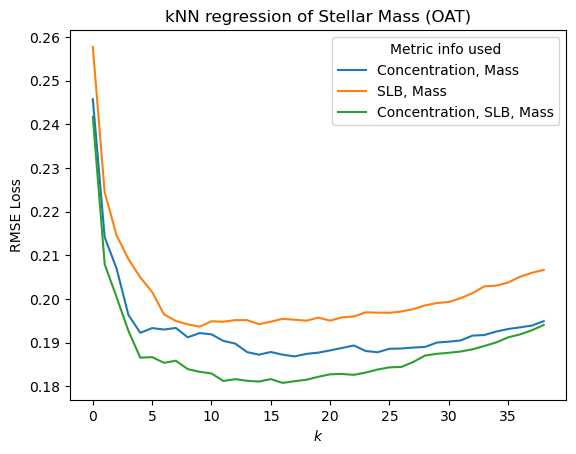

In [194]:
fig, ax = plt.subplots()
ax :plt.Axes = ax
ix = 4
ax.plot(loss_array[ix, 0], label="Concentration, Mass")
ax.plot(loss_array[0, ix], label="SLB, Mass")
ax.plot(loss_array[ix, ix], label="Concentration, SLB, Mass")

ax.legend(title="Metric info used")
ax.set(xlabel="$k$", ylabel="RMSE Loss", title="kNN regression of Stellar Mass (OAT)");